## PERC Rule for Pulmonary Embolism

### Seven Criteria of PERC Rule



1. Age < 50 years
2. Heart rate < 100 bpm
3. Oxygen saturation ≥ 95% 
4. No hemoptysis
5. No estrogen use
6. No prior venous thromboembolism (VTE)
7. No unilateral leg swelling
8. No recent surgery or trauma

## Initial

In [1]:
import sys
import os
from collections import defaultdict
sys.path.append(os.path.abspath(os.path.join('..')))
from calc_agent.perc_utils import *
from calc_agent.llm_run_hive import *

dataset = load_dataset("ncbi/MedCalc-Bench-v1.0")
df = dataset["train"].to_pandas()  # or "test"
df_test = dataset["test"].to_pandas()  # or "test"

perc_df = df[df["Calculator Name"] == "PERC Rule for Pulmonary Embolism"]

perc_df_test = df_test[df_test["Calculator Name"] == "PERC Rule for Pulmonary Embolism"]

# Load dataset
dataset = load_dataset("ncbi/MedCalc-Bench-v1.0")
df = dataset["train"].to_pandas()  # or "test"
df_test = dataset["test"].to_pandas()  # or "test"
# Filter for calculator name "PERC"

perc_df = df[df["Calculator Name"] == "PERC Rule for Pulmonary Embolism"]

perc_df_test = df_test[df_test["Calculator Name"] == "PERC Rule for Pulmonary Embolism"]


/Users/malthehli/Documents/ai_paper_tool/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/malthehli/Documents/ai_paper_tool/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Quick DA PERC

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 133 entries, 6670 to 6802
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Row Number                133 non-null    int64 
 1   Calculator ID             133 non-null    int64 
 2   Calculator Name           133 non-null    object
 3   Category                  133 non-null    object
 4   Output Type               133 non-null    object
 5   Note ID                   133 non-null    object
 6   Note Type                 133 non-null    object
 7   Patient Note              133 non-null    object
 8   Question                  133 non-null    object
 9   Relevant Entities         133 non-null    object
 10  Ground Truth Answer       133 non-null    object
 11  Lower Limit               133 non-null    object
 12  Upper Limit               133 non-null    object
 13  Ground Truth Explanation  133 non-null    object
dtypes: int64(2)

/var/folders/y5/cg9ckmtx691dkg8sg071p0qw0000gq/T/ipykernel_64210/3384332786.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perc_df["space_count"] = perc_df["Patient Note"].astype(str).apply(lambda x: x.count(" "))
/var/folders/y5/cg9ckmtx691dkg8sg071p0qw0000gq/T/ipykernel_64210/3384332786.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perc_df_test["space_count"] = perc_df_test["Patient Note"].astype(str).apply(lambda x: x.count(" "))


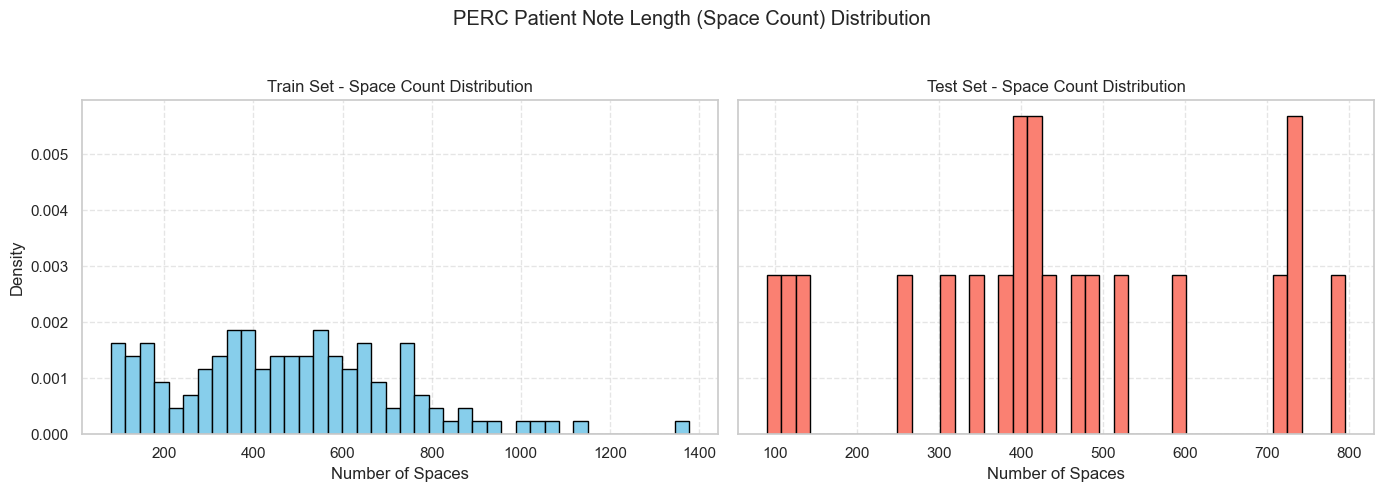

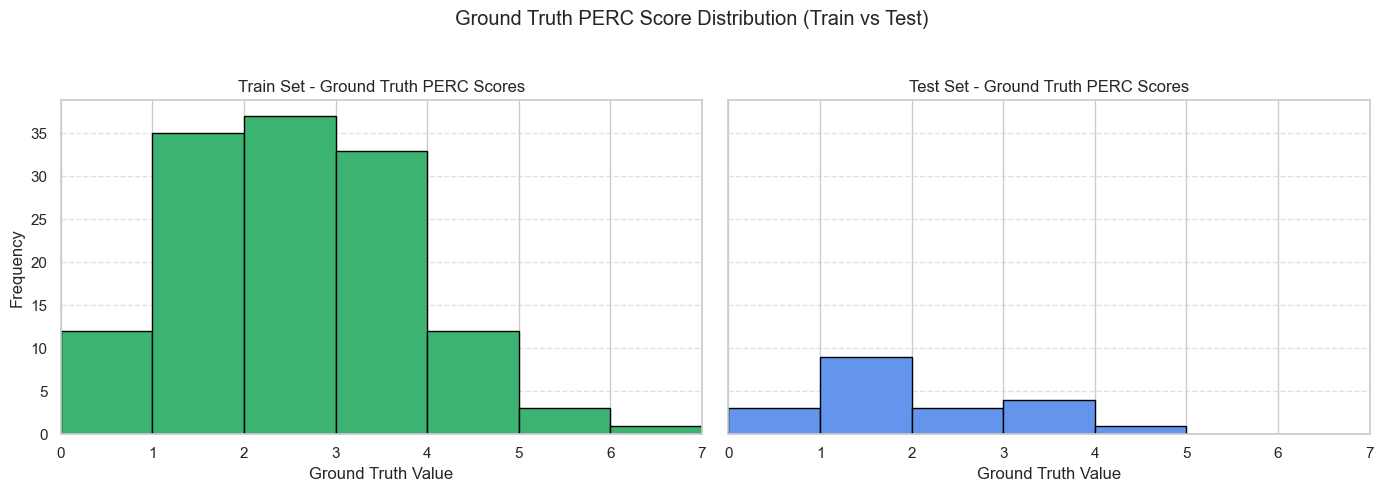

In [24]:
# 1. Basic info and data types
print("DataFrame Info:")
print(perc_df.info())
print("\n")

# 2. Check for missing values
print("Missing values per column:")
print(perc_df.isnull().sum())
print("\n")

# 3. Basic descriptive statistics for numeric columns
print("Descriptive statistics:")
print(perc_df.describe())
print("\n")

# 4. Count of unique values in categorical columns
categorical_cols = ['Calculator Name', 'Category', 'Output Type', 'Note Type']
for col in categorical_cols:
    print(f"Unique values in {col}:")
    print(perc_df[col].value_counts())
    print("\n")

# 5. Quick check: how many rows have Ground Truth Answer missing
missing_gt = perc_df['Ground Truth Answer'].isnull().sum()
print(f"Rows missing Ground Truth Answer: {missing_gt}")

# 6. Optional: Preview first few rows
print("\nPreview of first 5 rows:")
print(perc_df.head())

perc_df.head(5)

perc_df_test = df_test[df_test["Calculator Name"] == "PERC Rule for Pulmonary Embolism"]
perc_df_test.head(5)
perc_df["Relevant Entities"].iloc[0]


# Train: space count
perc_df["space_count"] = perc_df["Patient Note"].astype(str).apply(lambda x: x.count(" "))

# Test: space count
perc_df_test["space_count"] = perc_df_test["Patient Note"].astype(str).apply(lambda x: x.count(" "))

# Basic stats
print("Training Data")
print(perc_df["space_count"].describe())

print("\nTest Data")
print(perc_df_test["space_count"].describe())

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].hist(perc_df["space_count"], bins=40, color='skyblue', edgecolor='black', density=True)
axes[0].set_title("Train Set - Space Count Distribution")
axes[0].set_xlabel("Number of Spaces")
axes[0].set_ylabel("Density")
axes[0].grid(True, linestyle='--', alpha=0.5)

axes[1].hist(perc_df_test["space_count"], bins=40, color='salmon', edgecolor='black', density=True)
axes[1].set_title("Test Set - Space Count Distribution")
axes[1].set_xlabel("Number of Words")
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.suptitle("PERC Patient Note Length (Space Count) Distribution")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

"{'age': [73, 'years'], 'Heart Rate or Pulse': [92.0, 'beats per minute'], 'Hemoptysis': False, 'O₂ saturation percentage': [98.0, '%'], 'Unilateral Leg Swelling': False, 'Hormone use': True, 'Recent surgery or trauma': True, 'Previously documented Deep Vein Thrombosis': False, 'Previously Documented Pulmonary Embolism': False}"

# Ensure Ground Truth Answer is numeric and use .loc
perc_df.loc[:, "Ground Truth Answer"] = pd.to_numeric(perc_df["Ground Truth Answer"], errors="coerce")
perc_df_test.loc[:, "Ground Truth Answer"] = pd.to_numeric(perc_df_test["Ground Truth Answer"], errors="coerce")

# Drop NaNs
cleaned_train = perc_df["Ground Truth Answer"].dropna()
cleaned_test = perc_df_test["Ground Truth Answer"].dropna()

# Plot side-by-side histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

bins = range(0, 8)  # PERC scores range from 0 to 7

axes[0].hist(cleaned_train, bins=bins, color="mediumseagreen", edgecolor="black")
axes[0].set_title("Train Set - Ground Truth PERC Scores")
axes[0].set_xlabel("Ground Truth Value")
axes[0].set_ylabel("Frequency")
axes[0].set_xlim(0, 7)
axes[0].grid(axis="y", linestyle="--", alpha=0.6)

axes[1].hist(cleaned_test, bins=bins, color="cornflowerblue", edgecolor="black")
axes[1].set_title("Test Set - Ground Truth PERC Scores")
axes[1].set_xlabel("Ground Truth Value")
axes[1].set_xlim(0, 7)
axes[1].grid(axis="y", linestyle="--", alpha=0.6)

plt.suptitle("Ground Truth PERC Score Distribution (Train vs Test)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()







## Running prompt


In [2]:

# Running data:
    
# A.Simple Prompt (Patient Note + "Calculate Perc .. etc)

# B.Enhanced Pompt (A + criteria and formula for calculating PERC Score )

# C.Use Calculator (Extract criteria from the patient note and pass to calculator)


### A.Simple Prompt

In [3]:

sys_instruct = (
    "You are a clinical decision support assistant.\n"
)
prompt = (
    "Patient Note:\n"
    "Calculate the PERC score for this patient based on the 8 criteria below. "
    "Provide the output JSON object exactly matching this format ):\n\n"
    "{\n"
    "  \"Explanation\": \"<Concise summary explaining evaluation of each criterion>\"\n"
    "  \"Answer\": <integer equal to the total number of false criteria (sum of false values)>\n"
    "}\n"
)

results_df_simple= await run_models_with_output(
    sys_instruct = sys_instruct
    ,prompt=prompt,
    model_ids=model_ids,
    include_relevant_entities=False,
    full_df=True,max_tokens=1000,temperature=0.0,perc_df=perc_df
)



=== Evaluating model: Llama-3.3-70B-Instruct ===

Batch Progress: 100.0% (133/133)

Done ✅

=== Evaluating model: Med42-Qwen2.5-72B-v3-bi ===

Batch Progress: 100.0% (133/133)

Done ✅

=== Summary Counts ===
type
wrong      178
invalid     59
correct     29
Name: count, dtype: int64


### B.Enhanced Pompt

In [4]:
sys_instruct = (
    "You are a clinical decision support assistant.\n"
)
prompt = (
    "Calculate the PERC score for this patient based on the 8 criteria below. "
    "Explain how each criterion applies using the patient note and extracted entities, then return the result in the specified JSON format.\n\n"
    "Your task is to calculate the PERC (Pulmonary Embolism Rule-out Criteria) score for a patient using the provided note and extracted entities.\n\n"
    "There are 8 criteria. Each criterion is evaluated as either:\n"
    " - true: criterion met (meaning favorable condition, no risk factor present),\n"
    " - false: criterion not met (risk factor present).\n"
    "Each false criterion adds 1 point to the PERC score.\n\n"
    "PERC Criteria:\n"
    "1. Age < 50 years\n"
    "2. Heart rate < 100 beats per minute\n"
    "3. Oxygen saturation ≥ 95%\n"
    "4. No unilateral leg swelling\n"
    "5. No hemoptysis\n"
    "6. No recent trauma or surgery\n"
    "7. No history of deep vein thrombosis (DVT) or pulmonary embolism (PE)\n"
    "8. No hormone (estrogen) use\n\n"
    "If data for any criterion is missing or not explicitly mentioned, assume the criterion is met (true).\n\n"
    "First, provide a detailed step-by-step explanation about how you evaluated each criterion based on the patient data.\n\n"
    "Then, provide the output JSON object exactly matching this format (with no extra text):\n\n"
    "{\n"
    "  \"Explanation\": \"<Concise summary explaining evaluation of each criterion>\",\n"
    "  \"Criteria\": {\n"
    "    \"Age < 50\": true or false,\n"
    "    \"HR < 100\": true or false,\n"
    "    \"O₂ ≥ 95%\": true or false,\n"
    "    \"No hemoptysis\": true or false,\n"
    "    \"No Hormone use\": true or false,\n"
    "    \"No prior VTE or DVT\": true or false,\n"
    "    \"No unilateral leg swelling\": true or false,\n"
    "    \"No recent trauma or surgery\": true or false\n"
    "  },\n"
    "  \"Answer\": <integer equal to the total number of false criteria (sum of false values)>\n"
    "}\n"
)

results_df_enhanced_prompt= await run_models_with_output(
    sys_instruct = sys_instruct
    ,prompt=prompt,
    model_ids=model_ids,
    include_relevant_entities=False,
    full_df=True,max_tokens=1000,temperature=0.0,perc_df=perc_df
)



=== Evaluating model: Llama-3.3-70B-Instruct ===

Batch Progress: 100.0% (133/133)

Done ✅

=== Evaluating model: Med42-Qwen2.5-72B-v3-bi ===

Batch Progress: 100.0% (133/133)

Done ✅

=== Summary Counts ===
type
correct    178
wrong       85
invalid      3
Name: count, dtype: int64


### C.Use Calculator (Extract criteria from the patient note and pass to calculator)

In [5]:
sys_instruct = (
    "You are a clinical decision support assistant.\n"
)
prompt = """
Extract the following parameters from the patient note :

Output ONLY a JSON object containing the values for these parameters:
- age (number)
- heart_rate (number)
- oxygen_saturation (number)
- has_hemoptysis (true/false)
- on_estrogen (true/false)
- history_dvt_pe (true/false) 
- unilateral_leg_swelling (true/false)
- recent_trauma_or_surgery (true/false)

Example output:
{
  "age": 55,
  "heart_rate": 110,
  "oxygen_saturation": 94,
  "has_hemoptysis": false,
  "on_estrogen": true,
  "history_dvt_pe": false,
  "unilateral_leg_swelling": false,
  "recent_trauma_or_surgery": true
}
"""

## First run to only extract entities from the patient note
results_df_extract_entities = await run_models_with_output(
    sys_instruct = sys_instruct
    ,prompt=prompt,
    model_ids=model_ids,
    include_relevant_entities=False,
    full_df=True,max_tokens=1000,temperature=0.0,perc_df=perc_df
)
## Then run the calculator with the extracted entities
summary_df_computed=compute_perc_results(
    results_df_extract_entities)



=== Evaluating model: Llama-3.3-70B-Instruct ===

Batch Progress: 100.0% (133/133)

Done ✅

=== Evaluating model: Med42-Qwen2.5-72B-v3-bi ===

Batch Progress: 100.0% (133/133)

Done ✅

=== Summary Counts ===
type
invalid    266
Name: count, dtype: int64


/Users/malthehli/Documents/ai_paper_tool/calc_agent/perc_utils.py:516: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("model_id", dropna=False)


Simple Prompt Results:


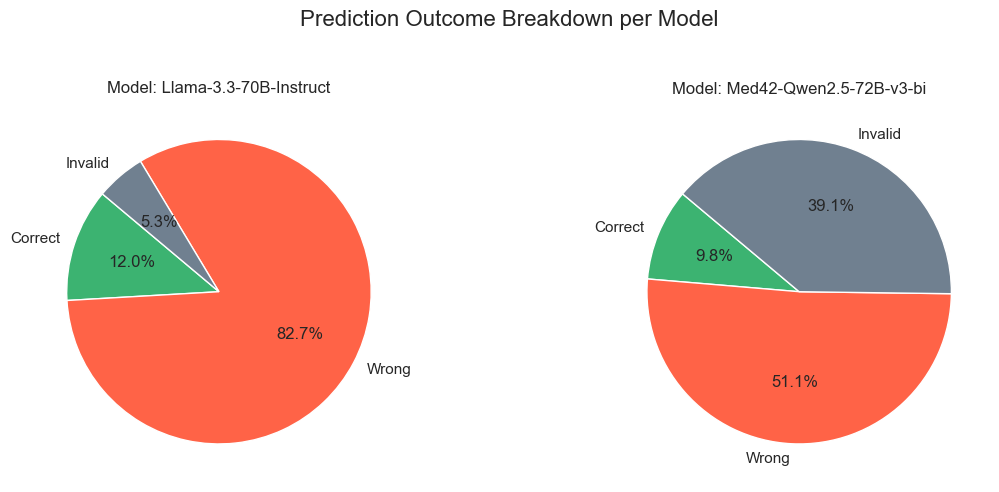

Enhanced Prompt Results:


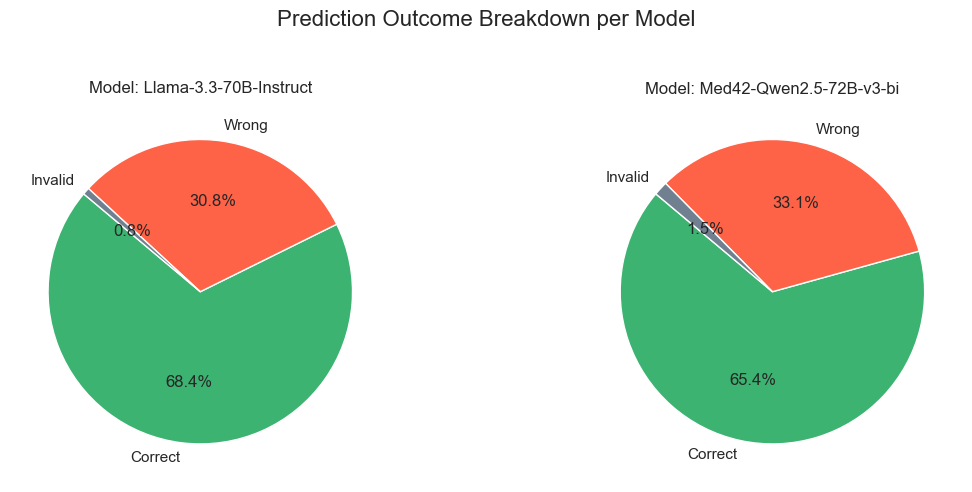

Computed Results:


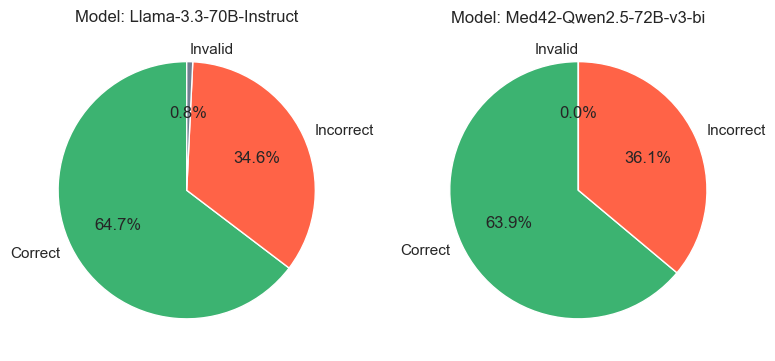

In [25]:
print("Simple Prompt Results:")
plot_df_pie(results_df_simple)
print("Enhanced Prompt Results:")
plot_df_pie(results_df_enhanced_prompt)
print("Computed Results:")
plot_recomputed_model_pies(summary_df_computed)

### Analyzing criteria

/Users/malthehli/Documents/ai_paper_tool/.venv/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.draw()
/Users/malthehli/Documents/ai_paper_tool/.venv/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.draw()
/Users/malthehli/Documents/ai_paper_tool/.venv/lib/python3.9/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.draw()
/Users/malthehli/Documents/ai_paper_tool/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


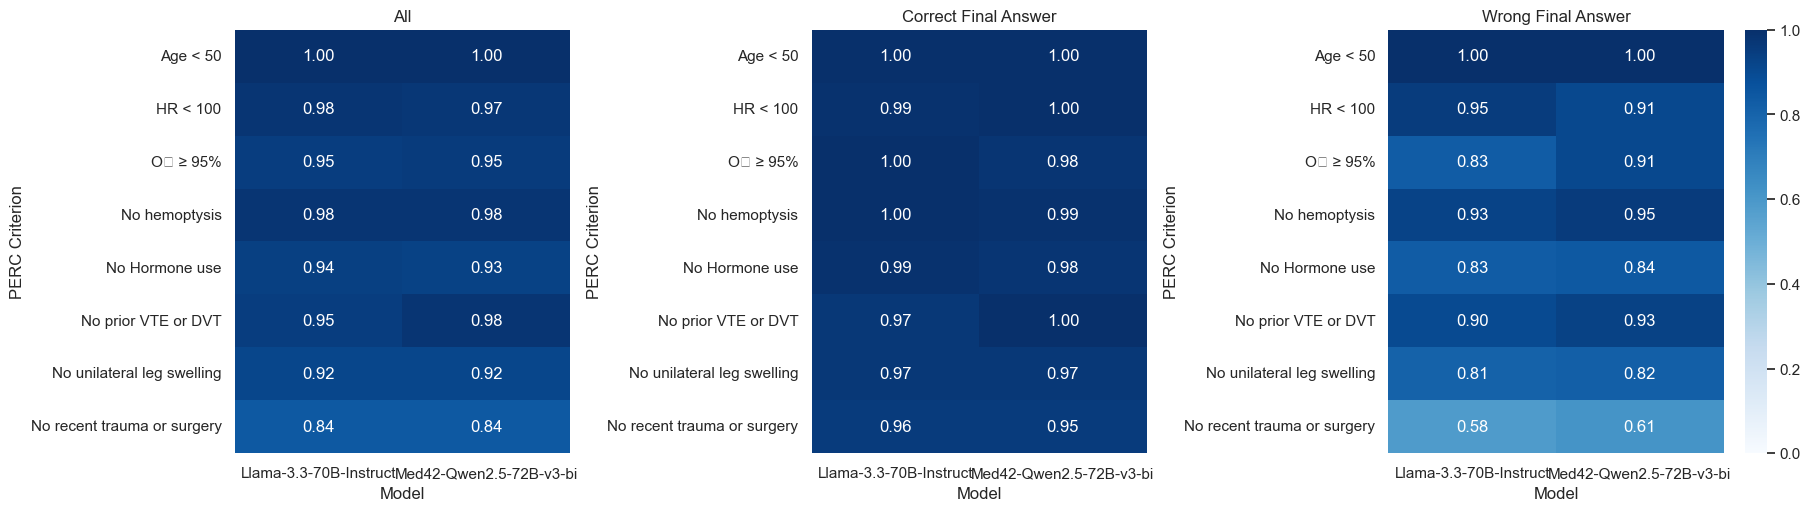

In [ ]:
plot_criteria_accuracy_by_outcome(results_df_enhanced_prompt)


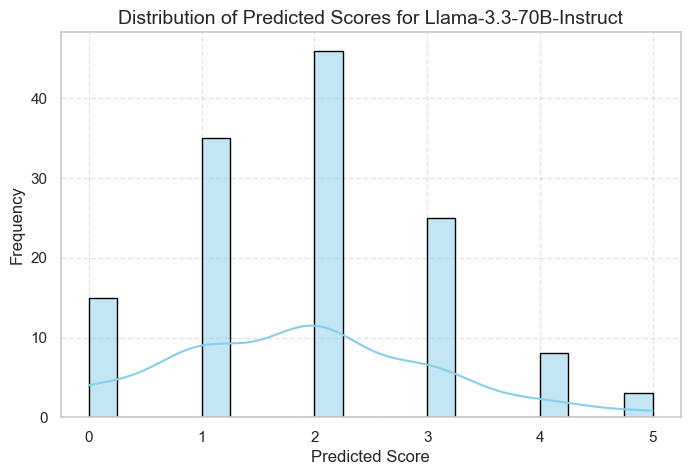

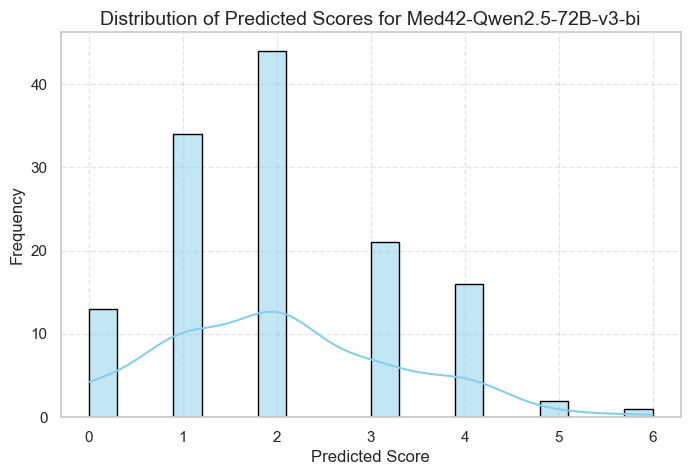

In [85]:

def plot_predicted_distribution(df, model_id):
    """
    Plots a distribution graph (histogram + KDE) of predicted scores for a given model_id.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing results_data.
        model_id (str): The model_id to filter on.
    """
    # filter df by model_id
    model_df = df[df["model_id"] == model_id]
    
    if model_df.empty:
        print(f"No data found for model_id = {model_id}")
        return
    
    plt.figure(figsize=(8, 5))
    
    sns.histplot(model_df["predicted"], kde=True, bins=20, color="skyblue", edgecolor="black")
    
    plt.title(f"Distribution of Predicted Scores for {model_id}", fontsize=14)
    plt.xlabel("Predicted Score")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle="--", alpha=0.5)
    
    plt.show()


plot_predicted_distribution(results_df_enhanced_prompt,model_ids[0])
plot_predicted_distribution(results_df_enhanced_prompt,model_ids[1])
